In [1]:
!pip install sentence_transformers
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/openai/CLIP.git to c:\users\yasha\appdata\local\temp\pip-req-build-ogh9cm0o
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\yasha\AppData\Local\Temp\pip-req-build-ogh9cm0o'

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import os
import pickle

import clip
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import torch
from torchvision import transforms
#from torchvision.transforms.functional import InterpolationMode 
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
df_train = pd.read_csv("./data/train.tsv", sep="\t")
df_dev = pd.read_csv("./data/dev.tsv", sep="\t")
df_test = pd.read_csv("./data/test.tsv", sep="\t")

df_train["label"] = df_train["label"].apply(lambda s: 1 if s == "informative" else 0)
df_dev["label"] = df_dev["label"].apply(lambda s: 1 if s == "informative" else 0)
df_test["label"] = df_test["label"].apply(lambda s: 1 if s == "informative" else 0)

In [4]:
df_train

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,california_wildfires,917791291823591425,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,1,informative,informative,Positive
1,california_wildfires,917791291823591425,917791291823591425_1,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,0,informative,not_informative,Negative
2,california_wildfires,917793137925459968,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,1,informative,informative,Positive
3,california_wildfires,917793137925459968,917793137925459968_1,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,1,informative,informative,Positive
4,california_wildfires,917793137925459968,917793137925459968_2,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,1,informative,informative,Positive
...,...,...,...,...,...,...,...,...,...
13603,hurricane_maria,912341945430798336,912341945430798336_0,11am #Maria update: tropical storm force winds...,data_image/hurricane_maria/25_9_2017/912341945...,1,informative,informative,Positive
13604,hurricane_irma,909936612196454403,909936612196454403_0,RT @WhereTraveler: Hurricane Irma Survival Gui...,data_image/hurricane_irma/19_9_2017/9099366121...,1,informative,not_informative,Negative
13605,hurricane_harvey,905581858485882881,905581858485882881_0,Thinking of doing a #DNA test? Buy a @FamilyTr...,data_image/hurricane_harvey/7_9_2017/905581858...,0,informative,not_informative,Negative
13606,hurricane_irma,909879746598723590,909879746598723590_0,Now blaming Hurricane Irma on Ursula the Witch...,data_image/hurricane_irma/18_9_2017/9098797465...,1,informative,not_informative,Negative


## Weak baseline

In [5]:
def evaluate(y_true, y_pred, y_pred_proba=None):
    # Accuracy
    print(f"Accuracy: {metrics.accuracy_score(y_true=y_true, y_pred=y_pred)}\n")
        
    # Classification report
    print(metrics.classification_report(y_true=y_true, y_pred=y_pred))

    _, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Confusion matrix
    cm = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax1, cmap=plt.cm.Blues, cbar=False)
    ax1.set(xlabel="Pred", ylabel="True", xticklabels=[0, 1], yticklabels=[0, 1], title="Confusion Matrix")

    if y_pred_proba is not None:
        # ROC curve/AUC score
        fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred_proba[:, 1], pos_label=1)
        auc_score = metrics.roc_auc_score(y_true=y_true, y_score=y_pred_proba[:, 1])
        ax2.plot(fpr, tpr, color="red", label=f"ROC Curve (AUC = {round(auc_score, 3)})")
        ax2.set_xlabel("False Positive Rate")
        ax2.set_ylabel("True Positive Rate")
        ax2.set_title("ROC Curve")
        ax2.legend(loc="best")

In [27]:
df_train['label'].value_counts()

label
1    8341
0    5267
Name: count, dtype: int64

In [28]:
df_dev['label'].value_counts()

label
1    1407
0     830
Name: count, dtype: int64

In [25]:

df_train['label'].value_counts().sort_values(ascending=False).index[0]

1

In [29]:
df_dev['label'].value_counts().sort_values(ascending=False).index[0]

1

In [30]:
pd.Series([majo]*len(df_train))

0        1
1        1
2        1
3        1
4        1
        ..
13603    1
13604    1
13605    1
13606    1
13607    1
Length: 13608, dtype: int64

In [6]:
def print_metrics(model, X, y):
    """Prints performance metrics"""
    y_pred = model.predict(X) # Predicted labels
    y_pred_proba = model.predict_proba(X) # Predicted probabilities
    
    # Test accuracy
    print(f"Accuracy: {metrics.accuracy_score(y_true=y, y_pred=y_pred)}\n")
    
    # Classification report
    print(metrics.classification_report(y_true=y, y_pred=y_pred))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Confusion matrix
    cm = metrics.confusion_matrix(y_true=y, y_pred=y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax1, cmap=plt.cm.Blues, cbar=False)
    ax1.set(
        xlabel="Pred", ylabel="True", 
        xticklabels=[0, 1], yticklabels=[0, 1], 
        title="Confusion Matrix"
    )

    # ROC curve/AUC score
    fpr, tpr, thresholds = metrics.roc_curve(
        y_true=y, y_score=y_pred_proba[:, 1], pos_label=1
    )
    auc_score = metrics.roc_auc_score(y_true=y, y_score=y_pred_proba[:, 1])
    ax2.plot(
        fpr, tpr, color="red", label=f"ROC Curve (AUC = {round(auc_score, 3)})"
    )
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("ROC Curve")
    ax2.legend(loc="best")

## CLIP

In [7]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
train_embeddings = []
batch_size = 64

for i in tqdm(range(0, len(df_train), batch_size)):
    fps = df_train["image"][i : i + batch_size].apply(lambda s: os.path.join("data", s)).tolist()
    image_batch = torch.cat([preprocess(Image.open(fp).convert("RGB")).unsqueeze(0) for fp in fps]).to(device)
    text_batch = clip.tokenize(df_train["tweet_text"][i : i + batch_size].apply(lambda s: s[:77])).to(device)

    with torch.no_grad():
        image_batch_features = model.encode_image(image_batch)
        text_batch_features = model.encode_text(text_batch)

    train_embeddings.extend(torch.cat((image_batch_features, text_batch_features), axis=1).tolist())

In [ ]:
with open("train_clip_embeddings.pkl", mode="wb") as f:
    pickle.dump(train_embeddings, f)

In [ ]:
dev_embeddings = []
batch_size = 64

for i in tqdm(range(0, len(df_dev), batch_size)):
    fps = df_dev["image"][i : i + batch_size].apply(lambda s: os.path.join("data", s)).tolist()
    image_batch = torch.cat([preprocess(Image.open(fp).convert("RGB")).unsqueeze(0) for fp in fps]).to(device)
    text_batch = clip.tokenize(df_dev["tweet_text"][i : i + batch_size].apply(lambda s: s[:77])).to(device)

    with torch.no_grad():
        image_batch_features = model.encode_image(image_batch)
        text_batch_features = model.encode_text(text_batch)

    dev_embeddings.extend(torch.cat((image_batch_features, text_batch_features), axis=1).tolist())

In [ ]:
with open("dev_clip_embeddings.pkl", mode="wb") as f:
    pickle.dump(dev_embeddings, f)

In [70]:
with open("train_clip_embeddings.pkl", mode="rb") as f:
    train_embeddings = pickle.load(f)

In [71]:
with open("dev_clip_embeddings.pkl", mode="rb") as f:
    dev_embeddings = pickle.load(f)

Accuracy: 0.8263521457965902

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      5267
           1       0.85      0.88      0.86      8341

    accuracy                           0.83     13608
   macro avg       0.82      0.81      0.81     13608
weighted avg       0.83      0.83      0.83     13608



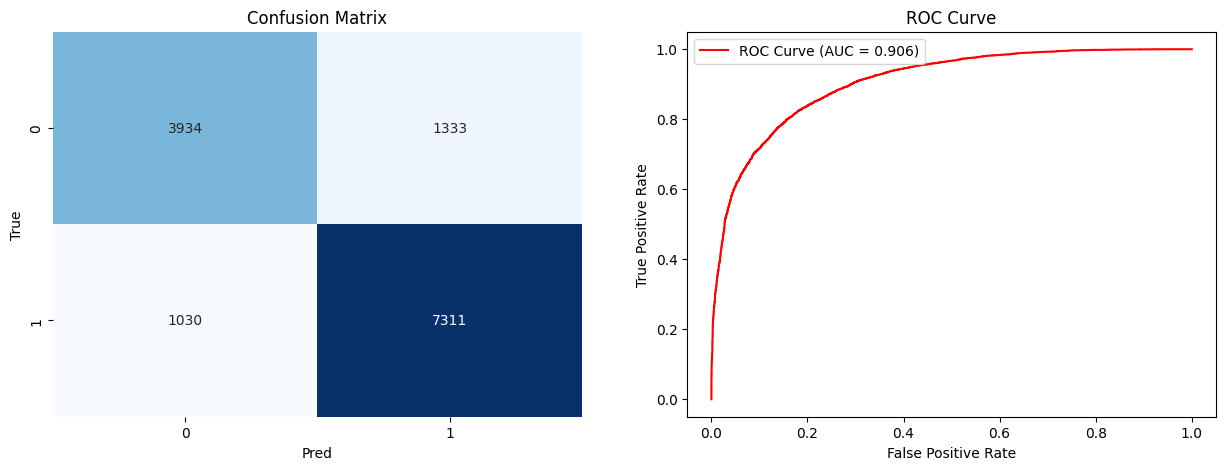

In [12]:
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(train_embeddings, df_train["label"])
print_metrics(clf, train_embeddings, df_train["label"])

Accuracy: 0.7961555654894948

              precision    recall  f1-score   support

           0       0.73      0.72      0.72       830
           1       0.83      0.84      0.84      1407

    accuracy                           0.80      2237
   macro avg       0.78      0.78      0.78      2237
weighted avg       0.80      0.80      0.80      2237



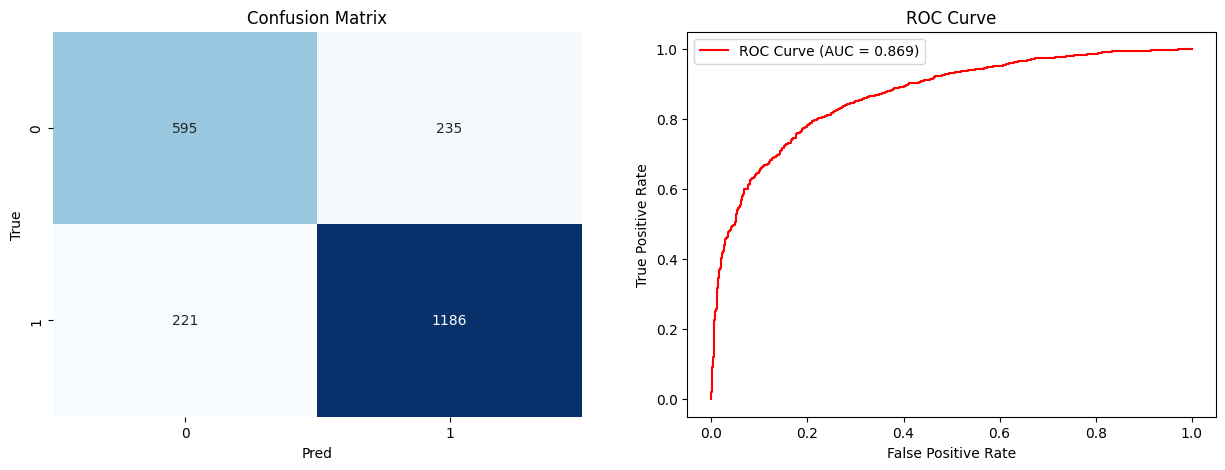

In [13]:
print_metrics(clf, dev_embeddings, df_dev["label"])

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5267
           1       1.00      1.00      1.00      8341

    accuracy                           1.00     13608
   macro avg       1.00      1.00      1.00     13608
weighted avg       1.00      1.00      1.00     13608



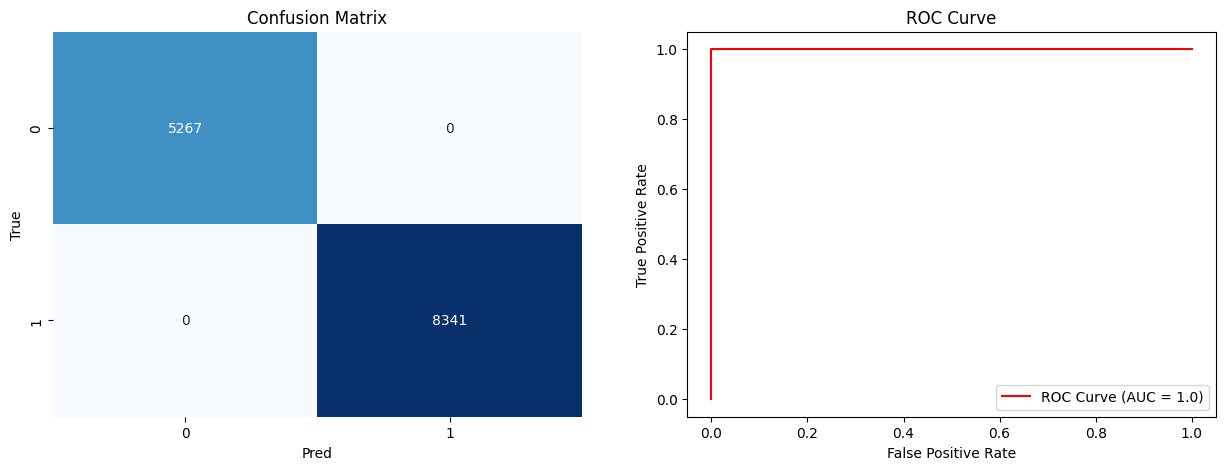

In [14]:
clf = RandomForestClassifier(random_state=42)
clf.fit(train_embeddings, df_train["label"])
print_metrics(clf, train_embeddings, df_train["label"])

In [24]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Accuracy: 0.7930263746088512

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       830
           1       0.82      0.85      0.84      1407

    accuracy                           0.79      2237
   macro avg       0.78      0.77      0.78      2237
weighted avg       0.79      0.79      0.79      2237



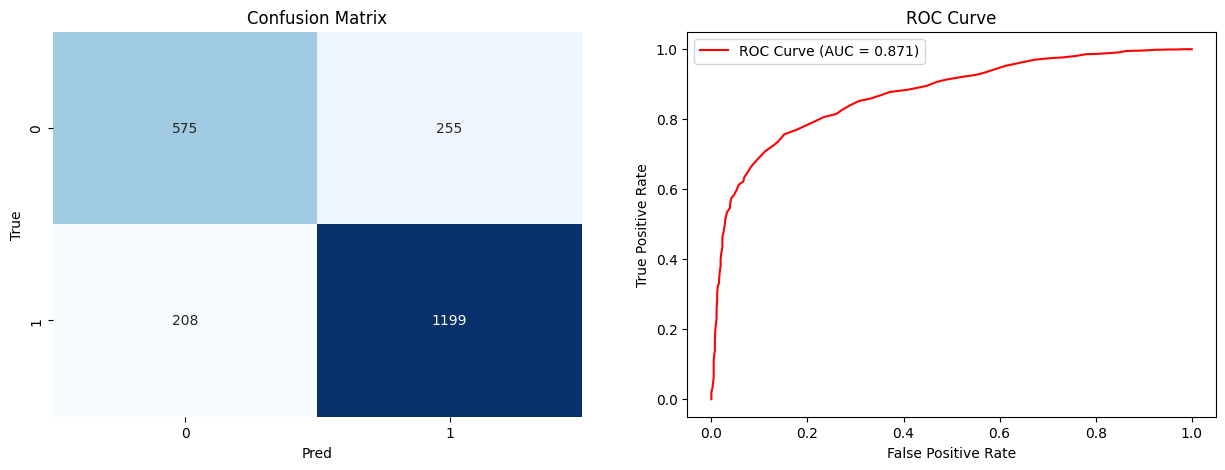

In [15]:
print_metrics(clf, dev_embeddings, df_dev["label"])

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START n_estimators=100............................................
[CV 1/3; 1/2] END .............n_estimators=100;, score=0.784 total time=  46.8s
[CV 2/3; 1/2] START n_estimators=100............................................
[CV 2/3; 1/2] END .............n_estimators=100;, score=0.781 total time=  47.4s
[CV 3/3; 1/2] START n_estimators=100............................................
[CV 3/3; 1/2] END .............n_estimators=100;, score=0.775 total time=  45.8s
[CV 1/3; 2/2] START n_estimators=200............................................
[CV 1/3; 2/2] END .............n_estimators=200;, score=0.792 total time= 1.5min
[CV 2/3; 2/2] START n_estimators=200............................................
[CV 2/3; 2/2] END .............n_estimators=200;, score=0.788 total time= 1.5min
[CV 3/3; 2/2] START n_estimators=200............................................
[CV 3/3; 2/2] END .............n_estimators=200;, 

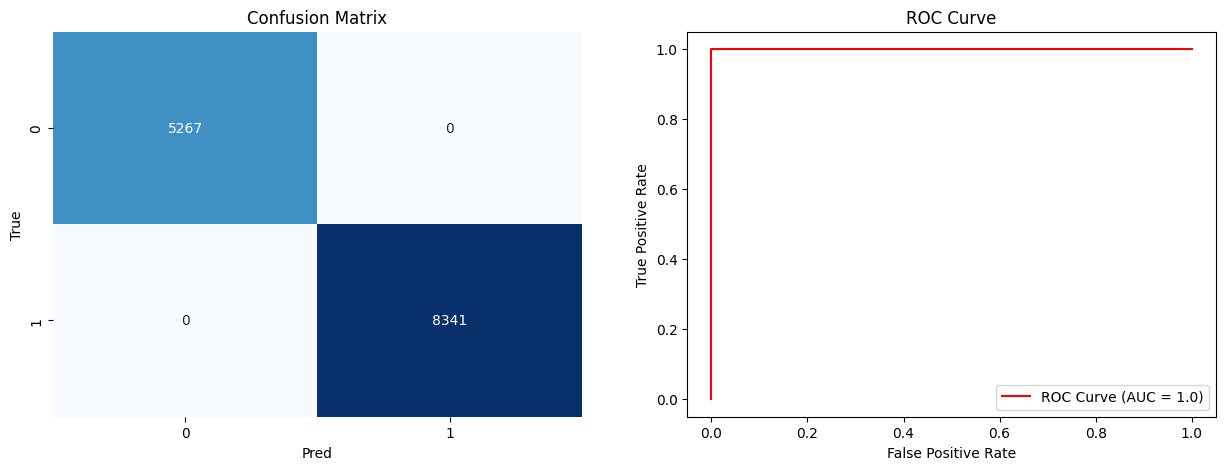

In [27]:
# Grid search
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
}
grid_search = GridSearchCV(clf, param_grid, cv=3,verbose=10)
grid_search.fit(train_embeddings, df_train["label"])

print_metrics(grid_search, train_embeddings, df_train["label"])
print(grid_search.best_params_)


Accuracy: 0.7903442109968708

              precision    recall  f1-score   support

           0       0.73      0.68      0.71       830
           1       0.82      0.86      0.84      1407

    accuracy                           0.79      2237
   macro avg       0.78      0.77      0.77      2237
weighted avg       0.79      0.79      0.79      2237



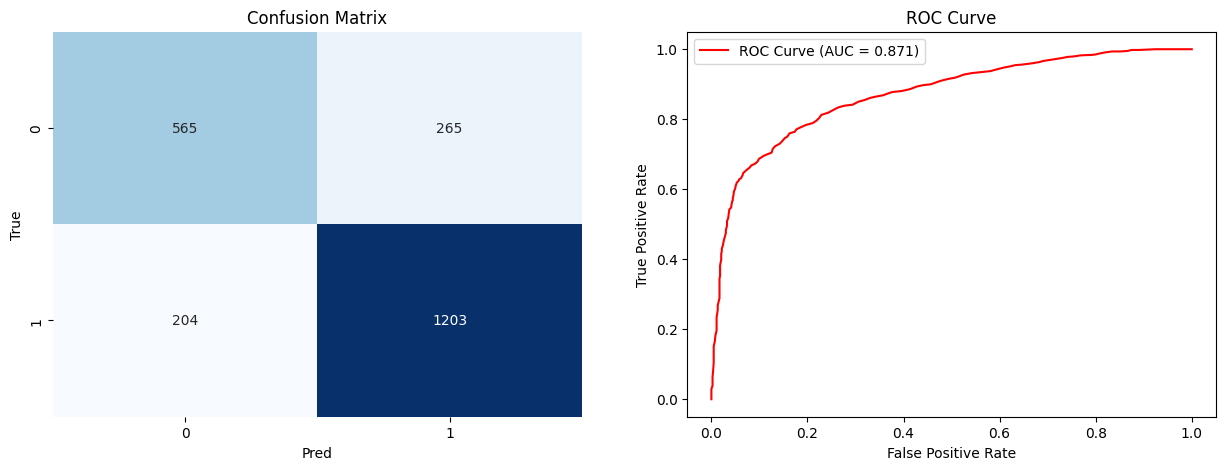

In [28]:
print_metrics(grid_search, dev_embeddings, df_dev["label"])

# Trying attention based multimodal classification - strong baseline

In [11]:
len(train_embeddings),len(train_embeddings[0])

(13608, 1024)

# 1024 columns, first 512 columns are for image embeddings, next 512 are for text embeddings

In [72]:
train_image_embeddings = torch.tensor([e[:512] for e in train_embeddings])
train_text_embeddings = torch.tensor([e[512:] for e in train_embeddings])

dev_image_embeddings = torch.tensor([e[:512] for e in dev_embeddings])
dev_text_embeddings = torch.tensor([e[512:] for e in dev_embeddings])

In [73]:
print(len(train_image_embeddings),len(train_image_embeddings[0]))
print(len(train_text_embeddings),len(train_text_embeddings[0]))
#train image and text embeddings are of same size

13608 512
13608 512


In [74]:
import torch.nn as nn
import torch.optim as optim

class ClipAttentionFusion(nn.Module):
    def __init__(self,  fusion_dim,embedding_dim = 512, num_classes=2):
        super(ClipAttentionFusion, self).__init__()
        self.text_attention = nn.Linear(embedding_dim, fusion_dim)
        self.image_attention = nn.Linear(embedding_dim, fusion_dim)
        
        # Fusion and classifier
        self.fusion_layer = nn.Linear(embedding_dim * 2, fusion_dim*8)
        self.activation = nn.ReLU()
        self.fusion_layer2 = nn.Linear(fusion_dim*8, fusion_dim*4)
        self.fusion_layer3 = nn.Linear(fusion_dim*4, fusion_dim*2)
        self.fusion_layer4 = nn.Linear(fusion_dim*2, fusion_dim)
        self.classifier = nn.Linear(fusion_dim, num_classes)

    def forward(self, text_embeddings, image_embeddings):
        # Apply attention
        text_attention_weights = torch.sigmoid(self.text_attention(text_embeddings))
        #we apply softmaxn so that weights sum up to 1 and they act as attention weights
        image_attention_weights = torch.sigmoid(self.image_attention(image_embeddings))

        # Weighted sum (element-wise multiplication with attention weights)
        text_fused = text_embeddings * text_attention_weights
        image_fused = image_embeddings * image_attention_weights

        # Fusion (concatenation of weighted features)
        fused = torch.cat((text_fused, image_fused), dim=1)
        fused = self.fusion_layer(fused)
        fused = self.activation(fused)
        fused = self.fusion_layer2(fused)
        fused = self.activation(fused)
        fused = self.fusion_layer3(fused)
        fused = self.activation(fused)
        fused = self.fusion_layer4(fused)
        fused = self.activation(fused)

        # Classifier
        output = self.classifier(fused)
        return output

In [91]:
import torch.nn as nn
import torch.optim as optim

class ClipAttentionFusion(nn.Module):
    def __init__(self,  fusion_dim,embedding_dim = 512, num_classes=2):
        super(ClipAttentionFusion, self).__init__()
        self.text_attention = nn.Linear(embedding_dim, fusion_dim)
        self.image_attention = nn.Linear(embedding_dim, fusion_dim)
        
        # Fusion and classifier
        #self.fusion_layer = nn.Linear(embedding_dim * 2, fusion_dim*8)
        self.fusion_layer = nn.Linear(embedding_dim * 2, fusion_dim)
        self.activation = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(fusion_dim)
        self.dropout = nn.Dropout(p=0.7)
        #self.fusion_layer2 = nn.Linear(fusion_dim*8, fusion_dim*4)
        #self.fusion_layer3 = nn.Linear(fusion_dim*4, fusion_dim*2)
        #self.fusion_layer4 = nn.Linear(fusion_dim*2, fusion_dim)
        self.classifier = nn.Linear(fusion_dim, num_classes)

    def forward(self, text_embeddings, image_embeddings):
        # Apply attention
        text_attention_weights = torch.sigmoid(self.text_attention(text_embeddings))
        #we apply softmaxn so that weights sum up to 1 and they act as attention weights
        image_attention_weights = torch.sigmoid(self.image_attention(image_embeddings))

        # Weighted sum (element-wise multiplication with attention weights)
        text_fused = text_embeddings * text_attention_weights
        image_fused = image_embeddings * image_attention_weights

        # Fusion (concatenation of weighted features)
        fused = torch.cat((text_fused, image_fused), dim=1)
        fused = self.fusion_layer(fused)
        fused = self.activation(fused)
        fused = self.dropout(self.batch_norm1(fused))
        
        

        #fused = self.fusion_layer2(fused)
        #fused = self.activation(fused)
        #fused = self.fusion_layer3(fused)
        #fused = self.activation(fused)
        #fused = self.fusion_layer4(fused)
        #fused = self.activation(fused)

        # Classifier
        output = self.classifier(fused)
        return output

In [92]:
from torch.utils.data import Dataset, DataLoader
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ClipDataset(Dataset):
    def __init__(self, text_embeddings, image_embeddings, labels):
        self.text_embeddings = text_embeddings.to(device)
        self.image_embeddings = image_embeddings.to(device)
        
        self.labels = torch.tensor([[0,1] if label == 1 else [1,0] for label in labels],dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text_embedding = self.text_embeddings[idx]
        image_embedding = self.image_embeddings[idx]
        label = self.labels[idx]
        return text_embedding, image_embedding, label

In [93]:
#creating dataloader
dataset = ClipDataset(train_image_embeddings, train_text_embeddings, df_train['label'])
dataset_dev = ClipDataset(dev_image_embeddings, dev_text_embeddings, df_dev['label'])

batch_size = 64  
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dataset_dev, batch_size=batch_size, shuffle=True)


In [94]:
fusion_dim = 512
model = ClipAttentionFusion(fusion_dim=fusion_dim,embedding_dim=512, num_classes=2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    for text_embeddings, image_embeddings, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        #print(text_embeddings.device,image_embeddings.device,labels.device,outputs.device)
        outputs = model(text_embeddings, image_embeddings)
        preds = torch.argmax(outputs,axis=1)
        #print(outputs.shape)
        #print(labels.shape)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total += labels.size(0)
        correct += (preds == torch.argmax(labels,axis=1)).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    accuracy = 100 * correct / total
    print(f"Train Accuracy: {accuracy:.2f}%")

        
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for text_embeddings, image_embeddings, labels in dev_loader:
            outputs = model(text_embeddings, image_embeddings)
            preds = torch.argmax(outputs,axis=1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            #print(probabilities.shape)
            #predicted = (probabilities > 0.5).float()  # Convert probabilities to binary predictions
            total += labels.size(0)
            correct += (preds == torch.argmax(labels,axis=1)).sum().item()
    epoch_loss = running_loss / len(dev_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_loss:.4f}")
    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")
    

Epoch [1/100], Loss: 0.6789
Train Accuracy: 64.69%
Epoch [1/100], Validation Loss: 0.5173
Validation Accuracy: 77.20%
Epoch [2/100], Loss: 0.5795
Train Accuracy: 73.33%
Epoch [2/100], Validation Loss: 0.4833
Validation Accuracy: 77.96%
Epoch [3/100], Loss: 0.5446
Train Accuracy: 75.51%
Epoch [3/100], Validation Loss: 0.4669
Validation Accuracy: 78.68%
Epoch [4/100], Loss: 0.5271
Train Accuracy: 76.46%
Epoch [4/100], Validation Loss: 0.4632
Validation Accuracy: 78.63%
Epoch [5/100], Loss: 0.5196
Train Accuracy: 76.75%
Epoch [5/100], Validation Loss: 0.4578
Validation Accuracy: 78.86%
Epoch [6/100], Loss: 0.5091
Train Accuracy: 77.56%
Epoch [6/100], Validation Loss: 0.4605
Validation Accuracy: 78.86%
Epoch [7/100], Loss: 0.4971
Train Accuracy: 78.11%
Epoch [7/100], Validation Loss: 0.4592
Validation Accuracy: 78.90%
Epoch [8/100], Loss: 0.4901
Train Accuracy: 78.36%
Epoch [8/100], Validation Loss: 0.4490
Validation Accuracy: 79.66%
Epoch [9/100], Loss: 0.4810
Train Accuracy: 79.04%
Epoch

In [ ]:
 with torch.no_grad():
        for text_embeddings, image_embeddings, labels in dev_loader:
            outputs = model(text_embeddings, image_embeddings)
            preds = torch.argmax(outputs,axis=1)

## Image Captions

In [29]:
!git clone https://github.com/salesforce/BLIP

Cloning into 'BLIP'...


In [16]:
#cd BLIP

/Users/rohan/Projects/multimodal-disaster-tweets-classification/BLIP


/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
from models.blip import blip_decoder

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
model = blip_decoder(pretrained=model_url, image_size=384, vit='base')
model.eval()
model = model.to(device)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((384, 384),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    # transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

In [ ]:
train_captions = []
batch_size = 64

for i in tqdm(range(0, len(df_train), batch_size)):
    fps = df_train["image"][i : i + batch_size].apply(lambda s: os.path.join("..", "data", s)).tolist()
    image_batch = torch.cat([transform(Image.open(fp).convert("RGB")).unsqueeze(0) for fp in fps]).to(device)

    with torch.no_grad():
        train_captions.append(model.generate(image_batch, sample=True, top_p=0.9, max_length=20, min_length=5))

image_caption = []
for captions in train_captions:
    image_caption.extend(captions)

df_train["image_caption"] = image_caption

df_train.to_csv("train_with_captions.csv", index=False)

In [ ]:
dev_captions = []
batch_size = 64

for i in tqdm(range(0, len(df_dev), batch_size)):
    fps = df_dev["image"][i : i + batch_size].apply(lambda s: os.path.join("..", "data", s)).tolist()
    image_batch = torch.cat([transform(Image.open(fp).convert("RGB")).unsqueeze(0) for fp in fps]).to(device)

    with torch.no_grad():
        dev_captions.append(model.generate(image_batch, sample=True, top_p=0.9, max_length=20, min_length=5))

image_caption = []
for captions in dev_captions:
    image_caption.extend(captions)

df_dev["image_caption"] = image_caption

df_dev.to_csv("dev_with_captions.csv", index=False)

In [19]:
cd ..

/Users/rohan/Projects/multimodal-disaster-tweets-classification


/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [30]:
df_train_with_captions = pd.read_csv("train_with_captions.csv")
df_dev_with_captions = pd.read_csv("dev_with_captions.csv")

In [34]:
df_train_with_captions

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image,image_caption
0,california_wildfires,917791291823591425,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,1,informative,informative,Positive,the burnt area in california on january 29
1,california_wildfires,917791291823591425,917791291823591425_1,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,0,informative,not_informative,Negative,the officers standing at podiums speaking to r...
2,california_wildfires,917793137925459968,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,1,informative,informative,Positive,fire damage in a house
3,california_wildfires,917793137925459968,917793137925459968_1,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,1,informative,informative,Positive,two women hugging in the middle of the night i...
4,california_wildfires,917793137925459968,917793137925459968_2,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,1,informative,informative,Positive,the fires burning over a house
...,...,...,...,...,...,...,...,...,...,...
13603,hurricane_maria,912341945430798336,912341945430798336_0,11am #Maria update: tropical storm force winds...,data_image/hurricane_maria/25_9_2017/912341945...,1,informative,informative,Positive,the severe weather on monday
13604,hurricane_irma,909936612196454403,909936612196454403_0,RT @WhereTraveler: Hurricane Irma Survival Gui...,data_image/hurricane_irma/19_9_2017/9099366121...,1,informative,not_informative,Negative,a marina with the sun setting on it
13605,hurricane_harvey,905581858485882881,905581858485882881_0,Thinking of doing a #DNA test? Buy a @FamilyTr...,data_image/hurricane_harvey/7_9_2017/905581858...,0,informative,not_informative,Negative,the website design for the new facebook page
13606,hurricane_irma,909879746598723590,909879746598723590_0,Now blaming Hurricane Irma on Ursula the Witch...,data_image/hurricane_irma/18_9_2017/9098797465...,1,informative,not_informative,Negative,"an old manuscript with a text that says `,'if ..."


In [35]:
df_train_with_captions["tweet_text_with_captions"] = df_train_with_captions.apply(
    lambda row: f"Tweet: {row['tweet_text']}\nImage Caption: {row['image_caption']}", axis=1)
df_dev_with_captions["tweet_text_with_captions"] = df_dev_with_captions.apply(
    lambda row: f"Tweet: {row['tweet_text']}\nImage Caption: {row['image_caption']}", axis=1)

In [23]:
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
train_embeddings = sentence_transformer.encode(df_train_with_captions["tweet_text_with_captions"], device=device)

In [ ]:
with open("train_with_captions_sbert_embeddings.pkl", mode="wb") as f:
    pickle.dump(train_embeddings, f)

In [ ]:
dev_embeddings = sentence_transformer.encode(df_dev_with_captions["tweet_text_with_captions"], device=device)

In [ ]:
with open("dev_with_captions_sbert_embeddings.pkl", mode="wb") as f:
    pickle.dump(dev_embeddings, f)

In [36]:
with open("train_with_captions_sbert_embeddings.pkl", mode="rb") as f:
    train_embeddings = pickle.load(f)

In [37]:
with open("dev_with_captions_sbert_embeddings.pkl", mode="rb") as f:
    dev_embeddings = pickle.load(f)

Accuracy: 0.7828483245149912

              precision    recall  f1-score   support

           0       0.76      0.64      0.69      5267
           1       0.79      0.88      0.83      8341

    accuracy                           0.78     13608
   macro avg       0.78      0.76      0.76     13608
weighted avg       0.78      0.78      0.78     13608



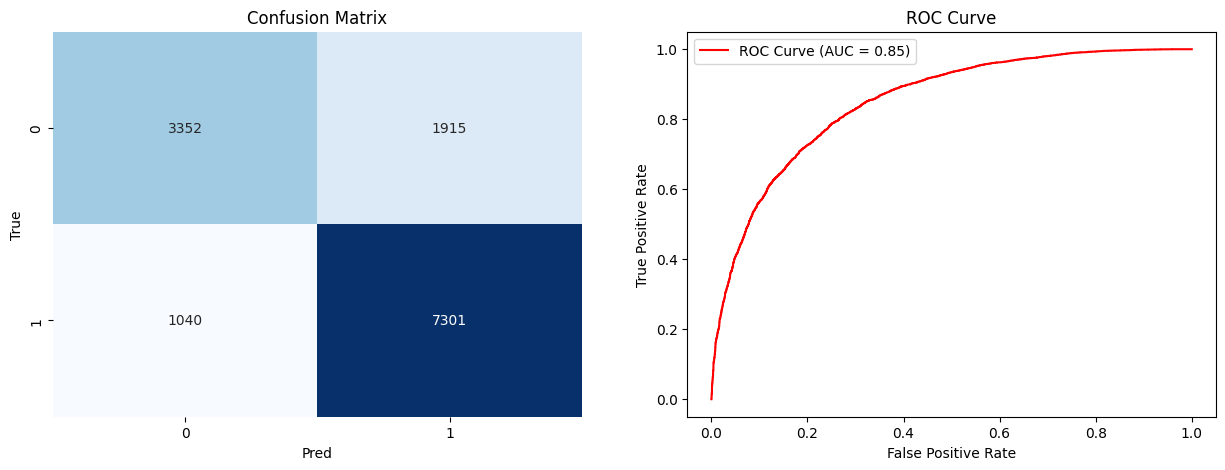

In [26]:
clf = LogisticRegression(random_state=42)
clf.fit(train_embeddings, df_train_with_captions["label"])
print_metrics(clf, train_embeddings, df_train_with_captions["label"])

Accuracy: 0.7590523021904336

              precision    recall  f1-score   support

           0       0.71      0.59      0.65       830
           1       0.78      0.86      0.82      1407

    accuracy                           0.76      2237
   macro avg       0.75      0.72      0.73      2237
weighted avg       0.75      0.76      0.75      2237



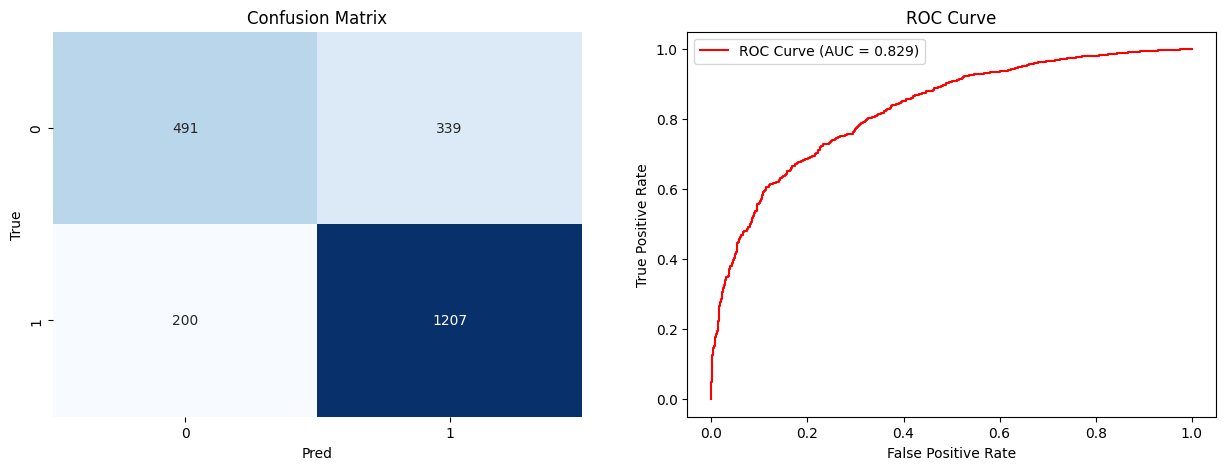

In [27]:
print_metrics(clf, dev_embeddings, df_dev_with_captions["label"])

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5267
           1       1.00      1.00      1.00      8341

    accuracy                           1.00     13608
   macro avg       1.00      1.00      1.00     13608
weighted avg       1.00      1.00      1.00     13608



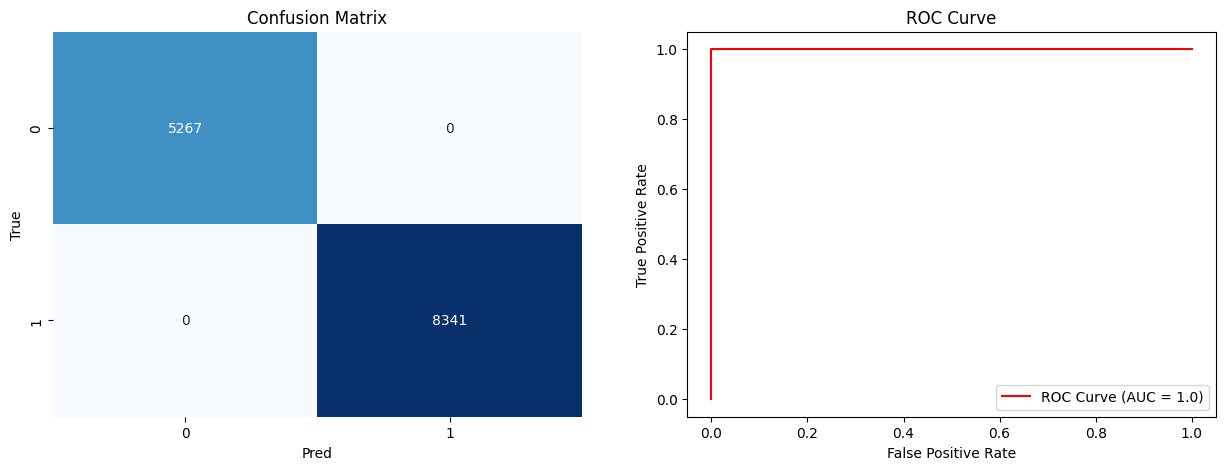

In [38]:
clf = RandomForestClassifier(random_state=42)
clf.fit(train_embeddings, df_train_with_captions["label"])
print_metrics(clf, train_embeddings, df_train_with_captions["label"])

In [40]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Accuracy: 0.7554760840411265

              precision    recall  f1-score   support

           0       0.72      0.55      0.63       830
           1       0.77      0.88      0.82      1407

    accuracy                           0.76      2237
   macro avg       0.75      0.71      0.72      2237
weighted avg       0.75      0.76      0.75      2237



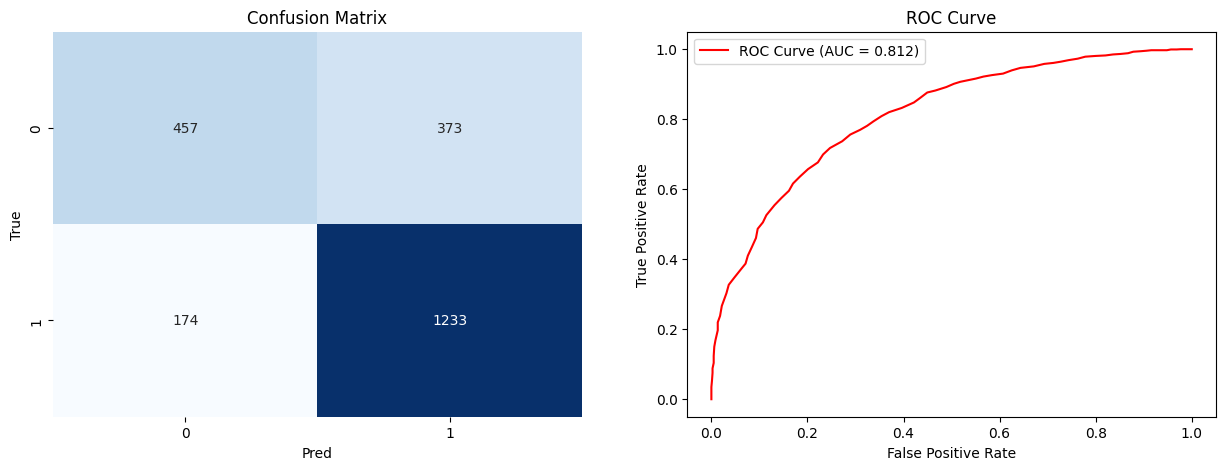

In [39]:
print_metrics(clf, dev_embeddings, df_dev_with_captions["label"])

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START n_estimators=100............................................
[CV 1/3; 1/2] END .............n_estimators=100;, score=0.769 total time=  24.8s
[CV 2/3; 1/2] START n_estimators=100............................................
[CV 2/3; 1/2] END .............n_estimators=100;, score=0.749 total time=  24.3s
[CV 3/3; 1/2] START n_estimators=100............................................
[CV 3/3; 1/2] END .............n_estimators=100;, score=0.759 total time=  24.2s
[CV 1/3; 2/2] START n_estimators=200............................................
[CV 1/3; 2/2] END .............n_estimators=200;, score=0.772 total time=  48.8s
[CV 2/3; 2/2] START n_estimators=200............................................
[CV 2/3; 2/2] END .............n_estimators=200;, score=0.753 total time=  48.9s
[CV 3/3; 2/2] START n_estimators=200............................................
[CV 3/3; 2/2] END .............n_estimators=200;, 

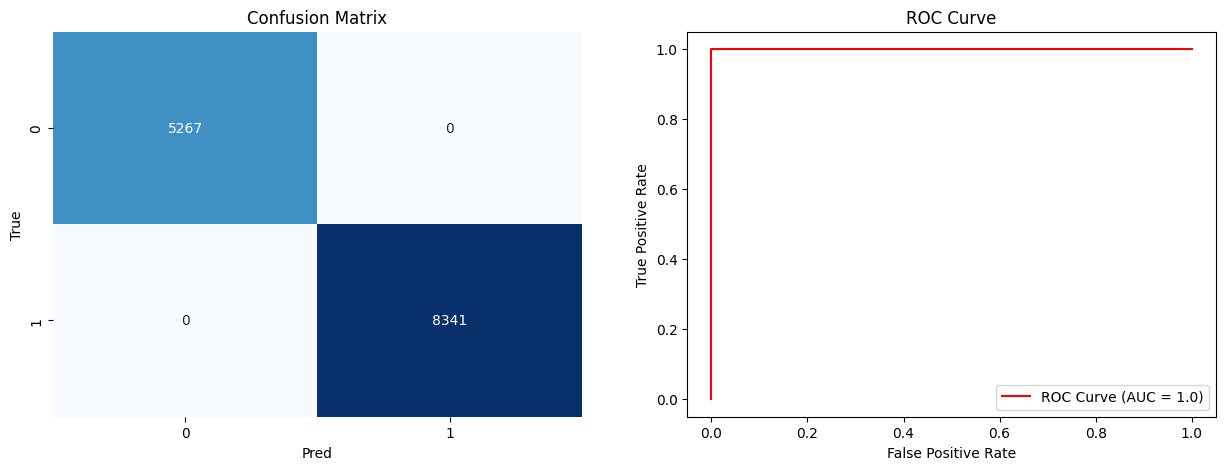

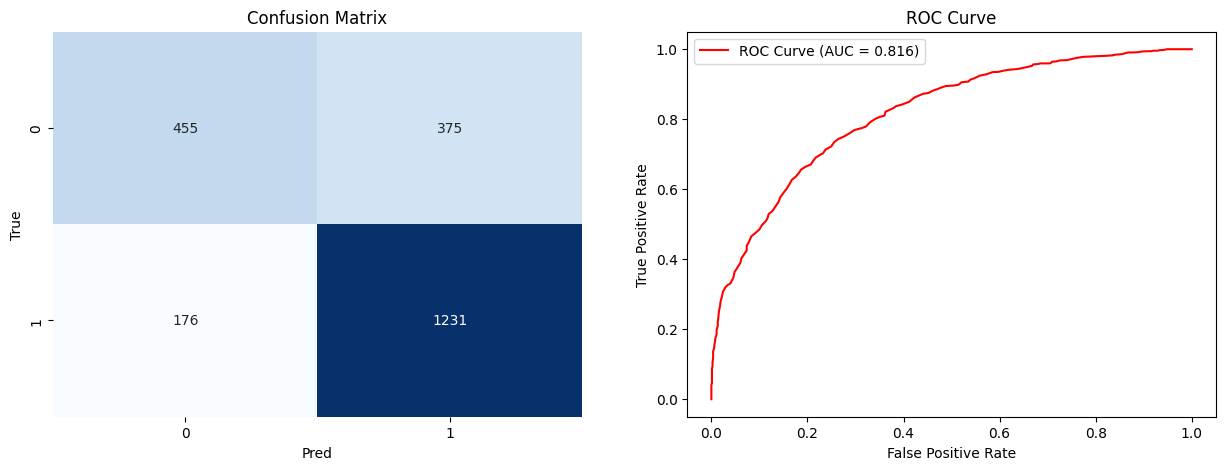

In [41]:
# Grid search
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
}
grid_search = GridSearchCV(clf, param_grid, cv=3,verbose=10)
grid_search.fit(train_embeddings, df_train_with_captions["label"])

print_metrics(grid_search, train_embeddings, df_train_with_captions["label"])
print(grid_search.best_params_)
print_metrics(grid_search, dev_embeddings, df_dev_with_captions["label"])

Accuracy: 0.753687974966473

              precision    recall  f1-score   support

           0       0.72      0.55      0.62       830
           1       0.77      0.87      0.82      1407

    accuracy                           0.75      2237
   macro avg       0.74      0.71      0.72      2237
weighted avg       0.75      0.75      0.75      2237



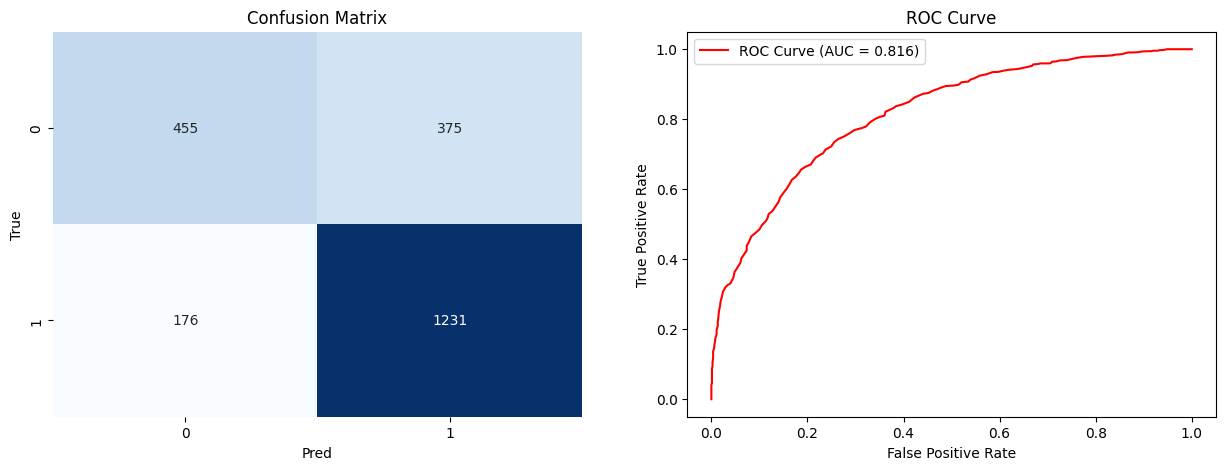

In [42]:
print_metrics(grid_search, dev_embeddings, df_dev_with_captions["label"])